**Model building for pneumonia data set for detection of lung opacity and detetcion the location of the infected region in the xray **

> EDA process already done and based on that and problem statement is for incdent detection of the object the model choosen was if MasRCNN



In [1]:

#Import necessary libraries to be used for the model building

import seaborn as sns

from glob import glob
import cv2
import os, zipfile, random, csv
import seaborn as sns

from glob import glob
import cv2
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import sys
import os
## set the root directory for the project
ROOT_DIR = '.'


In [2]:
## installation of pydicon seperately and then loading it
!pip install pydicom
import pydicom 

In [3]:
## version for tensorflow provided as 1.x, as maskrcnn model used is supportive if the 1.x tensofrlow version
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
## installation of specific version of keras and then restarting the runtime
#!pip install keras==2.1.6

In [5]:
## installation of specific version of h5py and then restarting the runtime
#!pip install h5py==2.10.0

In [6]:
## verifiying the tensorflow version which is loaded
import tensorflow
print(tensorflow.__version__)

1.15.2


In [7]:
## verifying the h5py version which is loaded
import h5py
print(h5py.__version__)

2.10.0


In [8]:
## mount the files from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
##Mask RCNN is loaded from matterport library
#!git clone https://www.github.com/matterport/Mask_RCNN.git


In [29]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [11]:
#!git clone https://github.com/leekunhee/Mask_RCNN.git

In [17]:
os.chdir('Mask_RCNN')
!python setup.py -q install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
zip_safe flag not set; analyzing archive contents...


In [12]:
os.chdir('../')

In [13]:
## download the coco weights from github which will be used for initial training and pre -trained weights are loaded
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#!ls -lh mask_rcnn_coco.h5

In [30]:
## check current directory
%pwd


'/content/drive/MyDrive/Kaggle'

In [15]:
# Kaggle Download - One time download for the pneumonia data set

"""!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

!kaggle competitions list -s pneumonia
KAGGLE_DIR = '/content/sample_data/Kaggle/'
%cd {KAGGLE_DIR}
!ls
competition_name = 'rsna-pneumonia-detection-challenge'
!mkdir {competition_name}
DOWNLOAD_DIR = KAGGLE_DIR+competition_name+'/'
print(DOWNLOAD_DIR)
os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_DIR
!kaggle competitions download -c {competition_name}
print('Download Complete')"""

"!pip uninstall -y kaggle\n!pip install --upgrade pip\n!pip install kaggle==1.5.6\n!kaggle -v\n\n!kaggle competitions list -s pneumonia\nKAGGLE_DIR = '/content/sample_data/Kaggle/'\n%cd {KAGGLE_DIR}\n!ls\ncompetition_name = 'rsna-pneumonia-detection-challenge'\n!mkdir {competition_name}\nDOWNLOAD_DIR = KAGGLE_DIR+competition_name+'/'\nprint(DOWNLOAD_DIR)\nos.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_DIR\n!kaggle competitions download -c {competition_name}\nprint('Download Complete')"

In [16]:
#!chmod 600 /content/sample_data/Kaggle/kaggle.json

In [17]:
#!kaggle competitions download -c rsna-pneumonia-detection-challenge

In [18]:
## unzip the files downloaded for train and testing
"""import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)"""

'import zipfile\nfor file in os.listdir():\n    if file.endswith(".zip"):\n        with zipfile.ZipFile(file, "r") as zip_file:\n            zip_file.extractall()\n        os.remove(file)'

In [20]:
## check the version of mask rcnn loaded
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages/mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 


In [21]:
## import the config and other utils from maskrcnn model
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN')) 
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [22]:
## import any other necessary libraries for running the model
import random
import math
import json
from imgaug import augmenters as iaa
from tqdm import tqdm

In [23]:
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [24]:

## configuration class and params for hyper tunning
class DetectorConfig(Config):
  
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU)

    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 ##Batch size is 8 (GPUs * images/GPU)
    
    BACKBONE = 'resnet50' ## eveulate performance using pre-trained coco , can also use resnet101

    TRAIN_ROIS_PER_IMAGE = 32 ## can be reduced to 16 and checked, indicates how many (good) positive + negative ROIs from the RPN to use for training the ODN network.
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (8, 16, 32, 1, 1)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4 ## set to 4 
    DETECTION_MAX_INSTANCES = 4 ## shd be 4
    DETECTION_MIN_CONFIDENCE = 0.6 ## reducing to identify all instances even false positive ones - >0.6
    DETECTION_NMS_THRESHOLD = 0.3 ## increae this? so to reduce the false positivies - 0.3
    #RPN_NMS_THRESHOLD  = 0.7 ## increases to 0.9


    STEPS_PER_EPOCH = 500 
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        4
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [25]:
## Classes and converting and resizing the image on the dataset
class DetectorDataset(utils.Dataset):
    

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [28]:
%pwd

'/content/drive/MyDrive'

In [31]:
train_labels = pd.read_csv('stage_2_train_labels.csv')

train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [32]:
train_labels.shape

(30227, 6)

In [33]:
train_labels.value_counts("Target")

Target
0    20672
1     9555
dtype: int64

In [34]:
train_labels_reslt = train_labels[train_labels['Target'] == 1]

In [35]:
train_labels_reslt.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [36]:
train_labels_reslt = train_labels_reslt.drop_duplicates(subset=['patientId'], keep='last')

In [37]:
train_labels_reslt.shape

(6012, 6)

In [38]:
train_labels_reslt.shape

(6012, 6)

In [39]:
train_labels_reslt

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1
...,...,...,...,...,...,...
30209,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,295.0,473.0,133.0,176.0,1
30215,c1cddf32-b957-4753-acaa-472ab1447e86,766.0,475.0,135.0,213.0,1
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1


In [40]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

In [41]:
## menthod to get the images list along with the annotations- ## only take images with Target as 1
def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    images = []
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
      #  print("target",row['Target'])
      if row['Target'] == 1:
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
        images.append(fp)
      else : continue
    return images, image_annotations 

In [42]:
image_fps, image_annotations = parse_dataset('stage_2_train_images', train_labels_reslt)

In [44]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [45]:
image

array([[0, 1, 2, ..., 2, 2, 2],
       [0, 1, 2, ..., 2, 2, 2],
       [0, 1, 2, ..., 3, 3, 3],
       ...,
       [1, 3, 4, ..., 7, 7, 7],
       [0, 2, 3, ..., 5, 5, 5],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [46]:
len(image_fps)

6012

In [47]:
len(image_annotations)

26684

In [48]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [49]:
## divide the list into training and validation dataset
image_fps_list = list(image_fps[:6012]) 


sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

5410 602


In [50]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, 1024, 1024)
dataset_train.prepare()

In [51]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    c30dc668-2110-4948-8b5c-ccf2af187953
 x                                           677.0
 y                                           535.0
 width                                       200.0
 height                                      410.0
 Target                                          1
 Name: 21409, dtype: object]

In [52]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, 1024, 1024)
dataset_val.prepare()

In [53]:
"""import tensorflow as tf
tf.compat.v1.disable_eager_execution()"""

'import tensorflow as tf\ntf.compat.v1.disable_eager_execution()'

In [54]:
LEARNING_RATE = 0.006 ## reduce the learning rate as the model is complex

In [55]:
# Train Mask-RCNN Model 
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True,  exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"]) 






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [56]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO)

In [57]:
NUM_EPOCHS = 30 ## running for higher epochs

model.train(dataset_train, dataset_val, 
            learning_rate= LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='heads',
            augmentation=augmentation)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ./pneumonia20220329T0540/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeD

In [58]:
#Fine-tune all layers. 
#model.train(dataset_train, dataset_val,
#            learning_rate=LEARNING_RATE/10,
#            epochs=5,
#            layers='all',
 #          augmentation=None)  ## no need to augment yet

#history1 = model.keras_model.history.history
#for k in history1: history[k] = history[k] + history1[k]

In [59]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,2.542327,0.015945,1.620543,0.097703,0.421937,0.386198,2.798432,0.021922,1.801094,0.108899,0.469606,0.396910
2,2.489003,0.016693,1.630235,0.080027,0.385494,0.376547,2.488162,0.016047,1.611473,0.103891,0.385486,0.371261
3,2.479410,0.015141,1.565537,0.128404,0.392033,0.378283,2.279830,0.014566,1.429006,0.100423,0.368239,0.367586
4,2.204503,0.014183,1.388760,0.074718,0.350368,0.376454,2.262871,0.014610,1.431525,0.092662,0.359224,0.364834
5,2.287974,0.014605,1.383591,0.103925,0.407638,0.378187,2.167222,0.013798,1.349238,0.101823,0.344967,0.357372
6,2.263051,0.014392,1.400108,0.095499,0.382157,0.370855,2.161146,0.013601,1.340779,0.099925,0.348461,0.358346
7,2.151727,0.013565,1.361608,0.079541,0.338030,0.358931,2.100745,0.013243,1.292298,0.102030,0.337571,0.355558
8,2.186878,0.014552,1.317945,0.127515,0.360890,0.365913,2.047556,0.013128,1.248858,0.100115,0.332921,0.352476
9,2.211010,0.013722,1.382338,0.114186,0.343874,0.356812,2.009138,0.013212,1.228566,0.099113,0.319549,0.348628
10,2.067617,0.011941,1.270217,0.062594,0.354195,0.368578,1.966935,0.012476,1.188887,0.096614,0.320081,0.348792


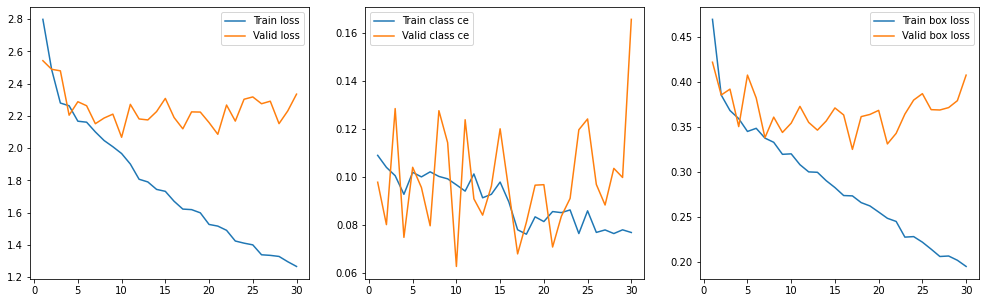

In [60]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

As per the above plotted graph it can be inferred that as the number of epochs are increasing the training loas, class loass and bbox loss has gone down. But the validation loass has been increasing pointing to that the model is overfitting after a certain time.

In [83]:
## we take the best performing epoch from all the runs and the saved weights to load the model in inference mode
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 10 2.067616858482361


In [79]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.6 ## reducing to identify all instances even false positive ones - >0.6
    DETECTION_NMS_THRESHOLD = 0.3 ## increae this? so to reduce the false positivies - 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
#model_path = model.find_last()
model_path = "/content/drive/MyDrive/Kaggle/pneumonia20220329T0540/mask_rcnn_pneumonia_0010.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/Kaggle/pneumonia20220329T0540/mask_rcnn_pneumonia_0010.h5
Re-starting from epoch 10


In [72]:
# Get filenames of test dataset DICOM images


test_image_fps = get_dicom_fps('/content/drive/MyDrive/Kaggle/stage_2_test_images')

In [81]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


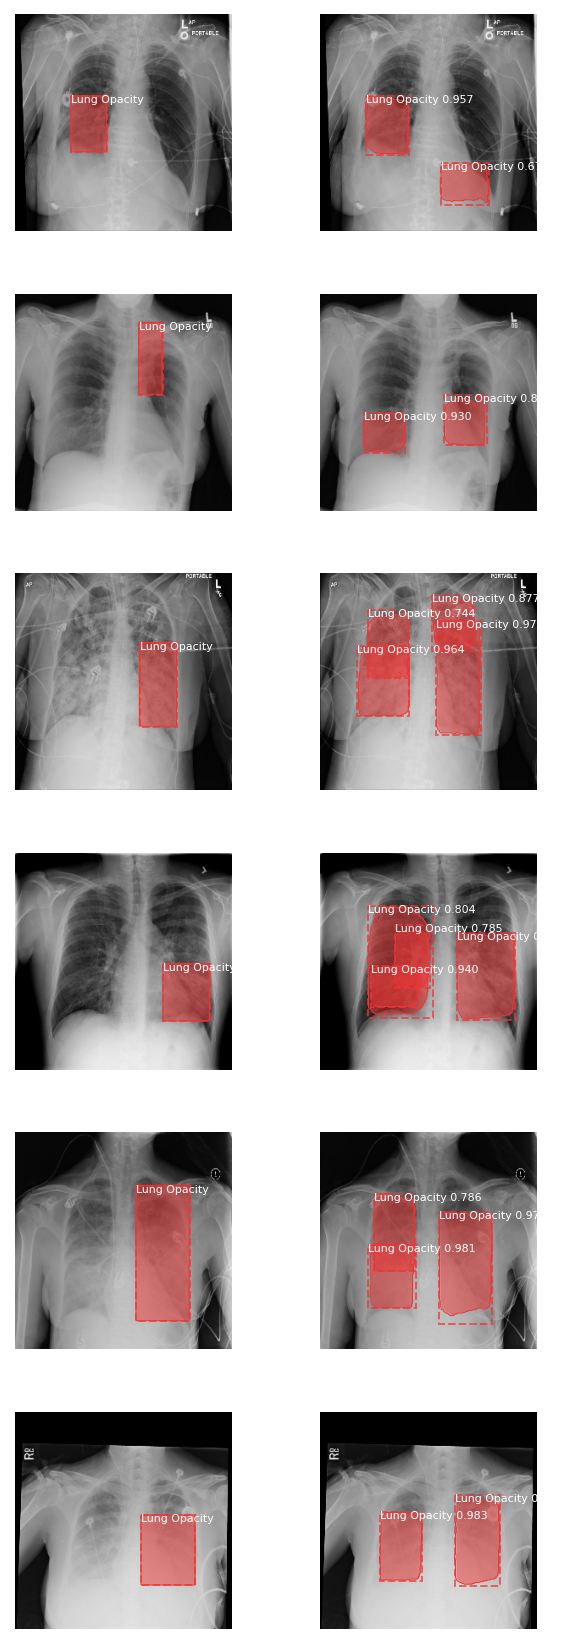

In [88]:
## plotting the model evaluation comparing the ground truth of the actual image and what is plotted from the model
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


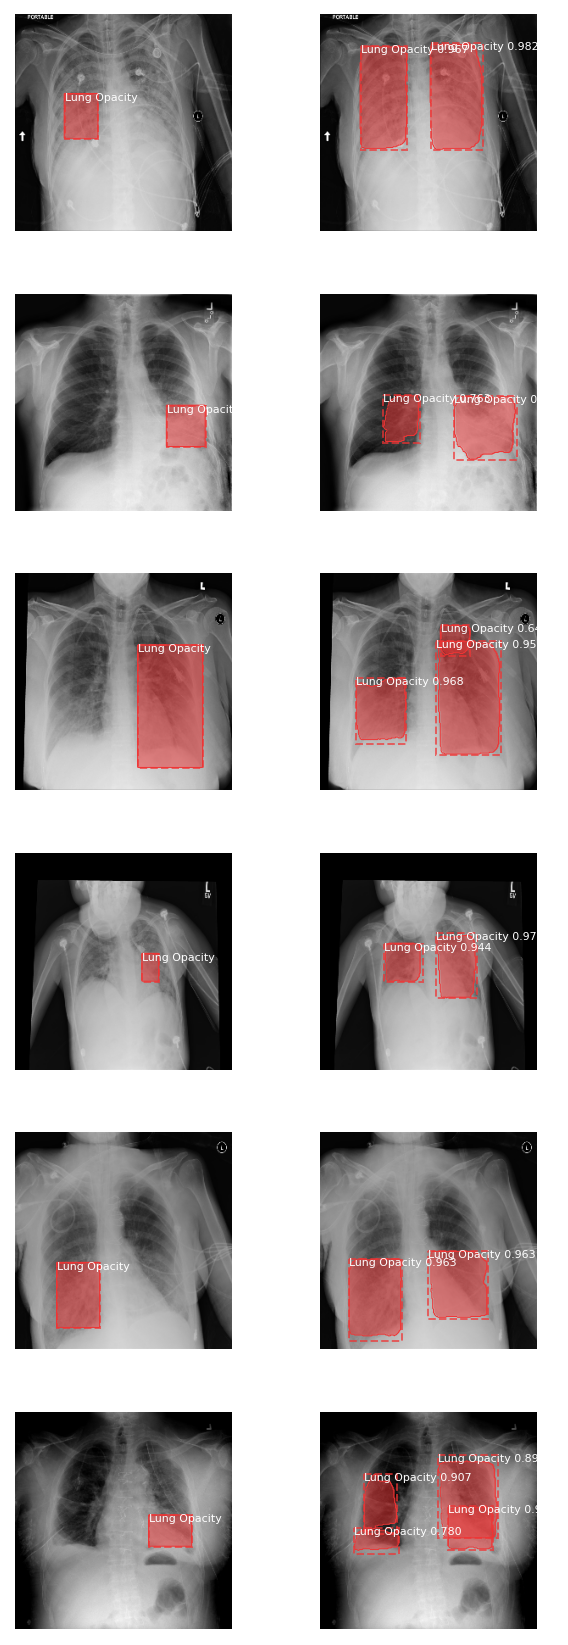

In [89]:
## plotting few more images
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


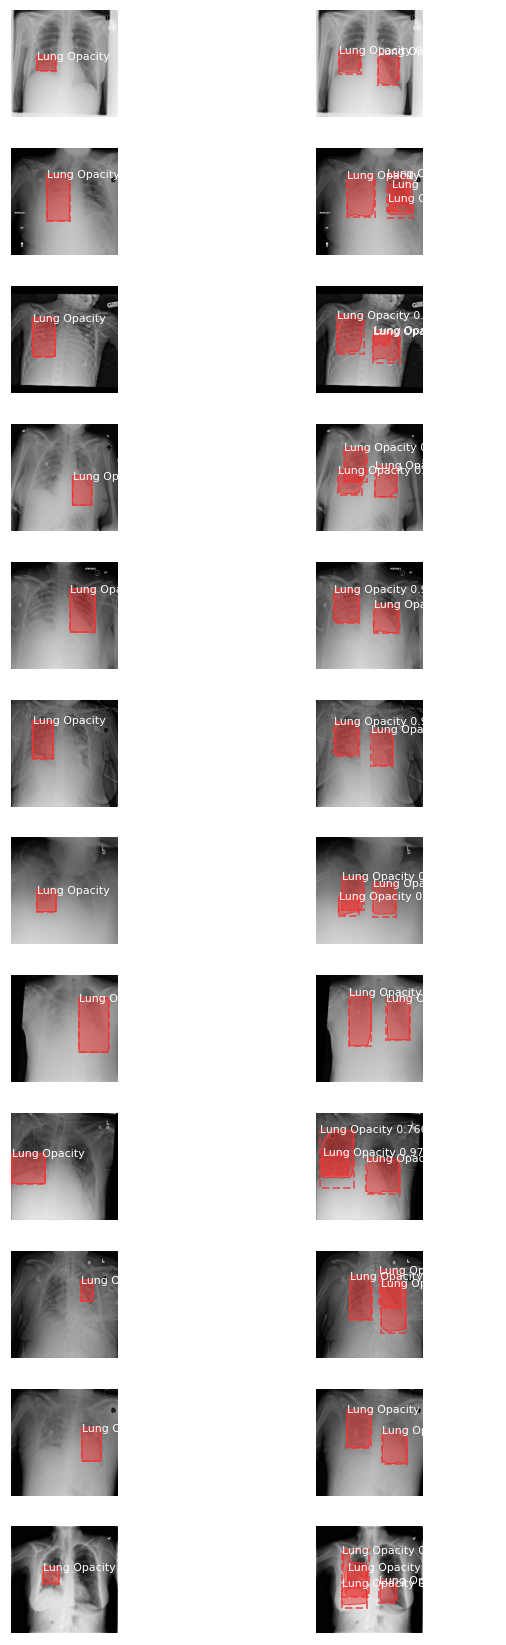

In [90]:
## plotting few more images
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(12):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(12, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(12, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [84]:
##Evaluation

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. 
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.35


In [66]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [75]:
# Make predictions on test images, write out sample submission 
ORIG_SIZE = 1024
def predict(image_fps, filepath='submission.csv', min_conf=0.95): 
    
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE 
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
        image, window, scale, padding, crop = utils.resize_image(
            image,
            min_dim=config.IMAGE_MIN_DIM,
            min_scale=config.IMAGE_MIN_SCALE,
            max_dim=config.IMAGE_MAX_DIM,
            mode=config.IMAGE_RESIZE_MODE)
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        r = results[0]

        out_str = ""
        out_str += patient_id 
        out_str += ","
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
  
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                       width*resize_factor, height*resize_factor)   
#                     bboxes_str = "{} {} {} {}".format(x1, y1, \
#                                                       width, height)
                    out_str += bboxes_str

        file.write(out_str+"\n")

In [86]:
## file submission with the prediction of x1, y1, width, height of the bb and confidence factor
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
print(submission_fp)
predict(test_image_fps, filepath=submission_fp)

./submission.csv


100%|██████████| 3000/3000 [16:30<00:00,  3.03it/s]


In [91]:
output = pd.read_csv(submission_fp, names=['patientId', 'PredictionString'])
output.head(10)

,patientId,PredictionString
0,2e6738e9-cda3-47a5-9975-6c5dc4ca6c63,0.98 620.0 336.0 296.0 272.0
1,0320cae5-82c5-460e-96f8-754354697b8e,NaN
2,1af976ad-7945-47e1-85fc-de29898ea31e,0.97 232.0 388.0 204.0 136.0
3,1bbb0121-c443-4b31-990e-c2837fb6f120,NaN
4,2173269e-6264-44fb-a0f0-9278e7e42c8f,NaN
5,1b07d941-e451-4ec8-8c64-f9fa43d5203c,0.96 232.0 616.0 224.0 196.0
6,0d1cf468-3791-40a7-8597-e0abb8b2d142,0.97 148.0 192.0 244.0 508.0 0.97 580.0 228.0...
7,14291892-506f-4f4d-8dca-57f456d2ba57,NaN
8,1378f79c-6ea0-41e9-98a9-1b15c2c54a7d,0.96 516.0 244.0 224.0 432.0
9,205f6d99-0870-499f-9644-92b98d985d62,NaN


1b8d026f-3989-4cd6-a4c7-4ed8fb8887d0
[ 92 155 136 216]
x 620 y 368 h 244 w 176
[101  60 134 102]
x 240 y 404 h 168 w 132


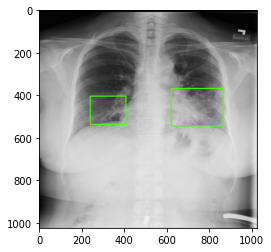

In [92]:
# show a few test image detection example
def visualize_img(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize_img()

In [ ]:

os.system('jupyter nbconvert --to html Capstone_MaskRCNN.ipynb')

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
%pwd

In [ ]:
os.system('jupyter nbconvert --to html Capstone_MaskRCNN.ipynb')

## Model Summary

MaskRCNN is a good fir for insatnce segematation problem

In conclusion Mask R-CNN is a great architecture for instance segmentation. However proper tuning of hyper-parameters is important to achieve its potential.